This initial processing is not specific to BATS DG data, but takes .nc files from a mission and computes seasonal background density profiles, runs the M/W velocity estimation procedure (along with the procedure to compute density profiles that use the same 'raw' density profiles used in velocity profile estimation. This allows density structure and velocity structure to be compared because profiles reflect sampling over the same temporal duration and spanning the same along-transect distance. 

In [2]:
# BATS (DG)s
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.7
ref_lon = 64.2
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3750  # 3900
# --- BIN PARAMETERS
GD = Dataset('BATs_2015_gridded_apr04.nc', 'r')
bin_depth = GD.variables['grid'][:]

# ----------------------------------------------------------------------------------------------------------------------
# ---- PROCESSING USING GLIDER PACKAGE
gs = 12
ge = 175
x = Glider(35, np.arange(gs, ge + 1), '/Users/jake/Documents/baroclinic_modes/DG/BATS_2015/sg035')

# Test alternate density computation
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg035_2015_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 450
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs:
    first = 0
else:
    first = np.where(profile_tags < gs)[0][-1] + 1
if profile_tags[-1] == ge + 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge)[0][0] - 1
d_in = range(first, last)
profile_tags = profile_tags[d_in]
neutral_density = dg_data['Neut_den'][0][0][0:limm, d_in]
t = dg_data['Temp'][0][0][0:limm, d_in]
s = dg_data['Sal'][0][0][0:limm, d_in]
lon = dg_data['Lon'][0][0][0:limm, d_in]
lat = dg_data['Lat'][0][0][0:limm, d_in]
dac_u = dg_data['Dac_u'][0][0][0]
dac_v = dg_data['Dac_v'][0][0][0]
d_time = dg_data['Time'][0][0][0:limm, d_in] - 366
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))
ref_lat = np.nanmean(lat)
time_rec_bin = np.nanmean(d_time, axis=0)
grid = dg_data['Depth'][0][0][0:limm, 0]
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
z = -1 * grid
sz_g = grid.shape[0]



In [3]:
# -- Compute density
sa, ct, theta, sig0, sig2, dg_N2 = x.density(grid, ref_lat, t, s, lon, lat)

In [4]:
# -- Background density profiles and seasonal variability
# Season Boundaries 
bd1 = 735750  # june1 (june1 = 735750) (may15 = 735733)
bd2 = 735856  # sept15

# split to account for horizontal gradients (should split for onshore/offshore of bermuda)
lon_lim = -64.09  # mid_split in lon
lat_lim = 31.65  # mid_split in lat 
# four boxes will be top left to bottom right clockwise 

# three seasons (winter, summer, fall)
# bounds are June 1 and Sept 15

# Winter 
d_winter_1 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
                       & ((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim))) )[0]
d_winter_2 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
                       & ((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim))) )[0]
d_winter_3 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
                       & ((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim))) )[0]
d_winter_4 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
                       & ((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim))) )[0]

d_summer_1 = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) 
                      & ((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim))) )[0]
d_summer_2 = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) 
                      & ((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim))) )[0]
d_summer_3 = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) 
                      & ((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim))) )[0]
d_summer_4 = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) 
                      & ((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim))) )[0]

d_fall_1 = np.where((time_rec_bin > bd2) 
                       & ((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim))) )[0]
d_fall_2 = np.where((time_rec_bin > bd2) 
                       & ((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim))) )[0]
d_fall_3 = np.where((time_rec_bin > bd2) 
                       & ((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim))) )[0]
d_fall_4 = np.where((time_rec_bin > bd2) 
                       & ((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim))) )[0]

bckgrds = [d_winter_1, d_winter_2, d_winter_3, d_winter_4, d_summer_1, d_summer_2, d_summer_3, d_summer_4,
          d_fall_1, d_fall_2, d_fall_3, d_fall_4]
bckgrds_info = ['Win_1', 'Win_2', 'Win_3', 'Win_4', 'Sum_1', 'Sum_2', 'Sum_3', 'Sum_4',
                'Fall_1', 'Fall_2', 'Fall_3', 'Fall_4']

# d_summer_w = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) & (np.nanmean(lon, axis=0) < lon_lim))[0]
# d_summer_e = np.where(((time_rec_bin > bd1) & (time_rec_bin < bd2)) & (np.nanmean(lon, axis=0) > lon_lim))[0]
# # (Winter 1 = Feb 2 - June 1) - (Winter 2 = Sept 15 - Nov 5)
# d_winter_w1 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
#                        & (np.nanmean(lon, axis=0) < lon_lim))[0]
# d_winter_e1 = np.where((time_rec_bin < bd1) & ((profile_tags < 60) | (profile_tags > 71))
#                        & (np.nanmean(lon, axis=0) > lon_lim))[0]
# d_winter_w2 = np.where((time_rec_bin > bd2) & ((profile_tags < 60) | (profile_tags > 71))
#                        & (np.nanmean(lon, axis=0) < lon_lim))[0]
# d_winter_e2 = np.where((time_rec_bin > bd2) & ((profile_tags < 60) | (profile_tags > 71))
#                        & (np.nanmean(lon, axis=0) > lon_lim))[0]

# bckgrds = [d_summer_w, d_summer_e, d_winter_w1, d_winter_e1, d_winter_w2, d_winter_e2]
# bckgrds_info = ['Summer West', 'Summer East','Winter1 West', 'Winter1 East','Fall West', 'Fall East']

# ABOVE SETS ORDER OF N2 PROFILES (different that order at the end)
# bckgrds_wins = np.array([bd1, bd2])  # summer boundaries
# bckgrds = [d_win1, d_sum, d_win2, d_eddy]  # KEY!! at the end, sets of profiles

salin_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
cons_t_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
sigma_theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
ddz_avg_sigma = np.nan * np.zeros((len(grid), len(bckgrds)))
N2_0 = np.nan * np.zeros(sigma_theta_avg.shape)
N2_ref = np.nan * np.zeros(sigma_theta_avg.shape)
N = np.nan * np.zeros(sigma_theta_avg.shape)
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    salin_avg[:, i] = np.nanmean(sa[:, inn], axis=1)
    cons_t_avg[:, i] = np.nanmean(ct[:, inn], axis=1)
    theta_avg[:, i] = np.nanmean(theta[:, inn], axis=1)
    sigma_theta_avg[:, i] = np.nanmean(neutral_density[:, inn], axis=1)
    ddz_avg_sigma[:, i] = np.gradient(sigma_theta_avg[:, i], z)
    go = ~np.isnan(salin_avg[:, i])
    N2_0[np.where(go)[0][0:-1], i] = gsw.Nsquared(salin_avg[go, i], cons_t_avg[go, i], grid_p[go], lat=ref_lat)[0]
    N2_0[N2_0[:, i] < 0] = np.nan  # 1 * 10**-7
    N2_ref[:, i] = nanseg_interp(grid, N2_0[:, i])
    # N2_ref[:, i] = savgol_filter(N2_ref[:, i], 5, 3)
N2_ref[-1, :] = N2_ref[-2, :] - 1 * 10**-9
N2 = N2_ref.copy()

N2_all = np.nan * np.zeros(len(grid))
N2_all[0:-1] = gsw.Nsquared(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p, lat=ref_lat)[0]
N2_all[-2:] = N2_all[-3]
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
N_all = np.sqrt(N2_all)
N2_all = savgol_filter(N2_all, 5, 3)
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:76: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:77: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:78: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice


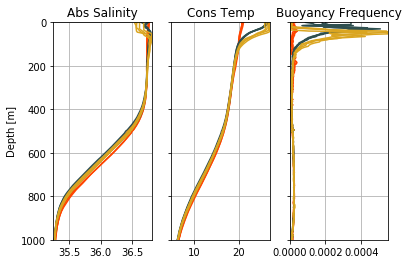

()

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
coli = '#FF4500', '#FF4500', '#FF4500', '#FF4500', '#2F4F4F', '#2F4F4F', '#2F4F4F', '#2F4F4F', '#DAA520', '#DAA520', '#DAA520', '#DAA520'
# cols = ['#2F4F4F', '#FF4500', '#DAA520']
# season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']
for i in range(len(bckgrds)):
    ax1.plot(salin_avg[:, i], grid, color=coli[i])
    ax2.plot(cons_t_avg[:, i], grid, color=coli[i])
    ax3.plot(N2_ref[:, i], grid, color=coli[i])
ax1.set_ylim([0, 1000])
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax1.set_xlim([35.25, 36.81])
ax1.set_ylabel('Depth [m]')
ax1.set_title('Abs Salinity')
ax2.set_xlim([5, 27])
ax2.set_title('Cons Temp')
ax3.set_xlim([0, 0.00055])
ax3.set_title('Buoyancy Frequency')
plot_pro(ax3)
# ax3.grid()
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/bats_dg_t_s_n2.jpg", dpi=300)

In [6]:
# -- compute M/W sections and compute velocity
# -- USING X.TRANSECT_CROSS_SECTION_1 (THIS WILL SEPARATE TRANSECTS BY TARGET OF EACH DIVE)
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])
# sigth_levels = np.concatenate([np.aranger(32, 36.6, 0.2), np.arange(36.6, 36.8, 0.05), np.arange(36.8, 37.4, 0.02)])

# --- SAVE so that we dont have to run transects every time
savee = 0
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, isopycdep, isopycx, mwe_lon, mwe_lat,\
    DACe_MW, DACn_MW, profile_tags_per, shear, v_g_east, v_g_north = x.transect_cross_section_1(grid, neutral_density,
                                                                                                ct, sa, lon, lat,
                                                                                                dac_u, dac_v,
                                                                                                profile_tags,
                                                                                                sigth_levels)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 'v_g_east': v_g_east, 'v_g_north': v_g_north}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_transects_test_3.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_transects_test_3.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0 = DACe_MW[0][0:-1].copy()
dacn_mw_0 = DACn_MW[0][0:-1].copy()
dg_v_0 = v_g[0][:, 0:-1].copy()
dg_v_e_0 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep = avg_sa_per_dep_0[0].copy()
dg_v_lon = mwe_lon[0][0:-1].copy()
dg_v_lat = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0 = profile_tags_per[0][0:-1].copy()
for i in range(1, len(v_g)):
    dace_mw_0 = np.concatenate((dace_mw_0, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0 = np.concatenate((dacn_mw_0, DACn_MW[i][0:-1]), axis=0)
    dg_v_0 = np.concatenate((dg_v_0, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0 = np.concatenate((dg_v_e_0, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0 = np.concatenate((dg_v_n_0, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep = np.concatenate((avg_ct_per_dep, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep = np.concatenate((avg_sa_per_dep, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep = np.concatenate((avg_sig0_per_dep, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon = np.concatenate((dg_v_lon, mwe_lon[i][0:-1]))
    dg_v_lat = np.concatenate((dg_v_lat, mwe_lat[i][0:-1]))
    dg_v_dive_no_0 = np.concatenate((dg_v_dive_no_0, profile_tags_per[i][0:-1]))

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin[np.in1d(profile_tags, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0 = np.concatenate((dg_mw_time_0, np.array([np.nanmean(tin)])))
        count = count + 1
        
prof_lon_i = np.nanmean(lon, axis=0)
prof_lat_i = np.nanmean(lat, axis=0)     

In [7]:
# Eta from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
for i in range(np.shape(avg_sig0_per_dep)[1]):  # loop over each profile
    # (average of four profiles) - (total long term average, that is seasonal)
    this_time = dg_mw_time_0[i]
    this_lon = dg_v_lon[i]
    this_lat = dg_v_lat[i]
    # match profile with appropriate background (in time and space)

    # first sort by quadrant 
    # quadrant 1 
    if (this_lon < lon_lim) & (this_lat > lat_lim): 
        if this_time < bd1: # winter 
            t_over = 0  
        elif (this_time > bd1) & (this_time < bd2):  # summer 
            t_over = 4  
        else:  # fall 
            t_over = 8  
    # quadrant 2        
    elif (this_lon > lon_lim) & (this_lat > lat_lim):  
        if this_time < bd1: # winter 
            t_over = 1  
        elif (this_time > bd1) & (this_time < bd2):  # summer 
            t_over = 5  
        else:  # fall 
            t_over = 9      
    # quadrant 3        
    elif (this_lon > lon_lim) & (this_lat < lat_lim):
        if this_time < bd1: # winter 
            t_over = 2  
        elif (this_time > bd1) & (this_time < bd2):  # summer 
            t_over = 6  
        else:  # fall 
            t_over = 10  
    # quadrant 4        
    else:
        if this_time < bd1: # winter 
            t_over = 3 
        elif (this_time > bd1) & (this_time < bd2):  # summer 
            t_over = 7  
        else:  # fall 
            t_over = 11  

    # ETA ALT (avg_sig0_per_dep and sigma_theta_avg are really neutral density, imported from matlab binning)
    # match profile (really avg of 3/4 profiles) with one of 4 seasonal background profiles
    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over])        
            
    # ETA ALT 2
    # find appropriate average background profiles
    avg_a_salin = salin_avg[:, t_over]
    avg_c_temp = cons_t_avg[:, t_over]

    # compute density at every depth for every profile using sa and ct profiles (really avg of 3/4 profiles)
    # eta_alt_2 is compute using a local reference pressure
    # loop over each bin depth
    for j in range(2, len(grid) - 2):
        if ~np.isnan(avg_sa_per_dep[j, i]):
            # profile density at depth j with local reference pressure (call p2)
            this_sigma = gsw.rho(avg_sa_per_dep[j, i], avg_ct_per_dep[j, i], grid_p[j]) - 1000      # profile density
            # background density at points above and below p2 with local reference pressure (p2)
            this_sigma_avg = gsw.rho(avg_a_salin[j-2:j+3], avg_c_temp[j-2:j+3], grid_p[j]) - 1000
            d_anom_alt[j, i] = this_sigma - this_sigma_avg[1]
            gradient_alt[j, i] = np.nanmean(np.gradient(this_sigma_avg, z[j-2:j+3]))
            # gradient_alt[j, i] = (this_sigma_avg[0] - this_sigma_avg[2]) / (grid[j-1] - grid[j+1])
            eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, avg_sig0_per_dep[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[0:idx + 3], z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[idx - 2:idx + 3], z_rho_1) - grid[j]

# eta_alt = gamma / ddz 
# eta_alt_2 = local potential density / local ddz 
# eta_alt_3 = direct search for gamma on background profile (difference in depths then computed)
eta_alt_0 = eta_alt.copy()

In [32]:
np.abs(eta_alt_3[200, :])

array([             nan,   1.26852738e+01,   1.83863684e+01,
         1.98996068e+01,              nan,              nan,
         9.47001569e+00,   4.43629089e+00,   1.15242417e+01,
                    nan,              nan,   2.52276175e+01,
                    nan,              nan,   1.94121150e+01,
         1.74090511e+01,   1.17910100e+01,              nan,
                    nan,   3.46452516e+01,   5.32130862e+01,
         5.99406817e+01,              nan,              nan,
         8.93984270e+01,   7.55708664e+01,   6.55976092e+01,
                    nan,              nan,   9.06367624e+00,
                    nan,              nan,   1.50643913e+00,
                    nan,              nan,   3.76728965e+01,
         2.69756068e+01,   7.48249371e+00,              nan,
                    nan,   1.21678292e+00,              nan,
                    nan,   3.54943902e+01,              nan,
                    nan,   3.18199789e+01,   6.29207765e+00,
         9.14353308e-01,

In [8]:
# --- ETA COMPUTED FROM INDIVIDUAL DENSITY PROFILES (AND PE from function)
G_all, Gz_all, c_all, epsilon_all = vertical_modes(N2_all, grid, omega, mmax)
eta_per_prof = np.nan * np.ones(sig2.shape)
eta_per_prof_3 = np.nan * np.ones(sig2.shape)
d_anom_prof = np.nan * np.ones(sig2.shape)
for i in range(lon.shape[1]):
    this_lon = np.nanmean(lon[:, i])
    this_lat = np.nanmean(lat[:, i])
    this_time = np.nanmean(d_time[:, i])    
    
    # first sort by quadrant 
    # quadrant 1 
    if (this_lon < lon_lim) & (this_lat > lat_lim): 
        if this_time < bd1: # winter 
            t_over = 0  
        elif (this_time > bd1) & (this_time < bd2):  # summer 
            t_over = 4  
        else:  # fall 
            t_over = 8  
    # quadrant 2        
    elif (this_lon > lon_lim) & (this_lat > lat_lim):  
        if this_time < bd1: # winter 
            t_over = 1  
        elif (this_time > bd1) & (this_time < bd2):  # summer 
            t_over = 5  
        else:  # fall 
            t_over = 9      
    # quadrant 3        
    elif (this_lon > lon_lim) & (this_lat < lat_lim):
        if this_time < bd1: # winter 
            t_over = 2  
        elif (this_time > bd1) & (this_time < bd2):  # summer 
            t_over = 6  
        else:  # fall 
            t_over = 10  
    # quadrant 4        
    else:
        if this_time < bd1: # winter 
            t_over = 3 
        elif (this_time > bd1) & (this_time < bd2):  # summer 
            t_over = 7  
        else:  # fall 
            t_over = 11  

    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over])

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, neutral_density[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[0:idx + 3],
                                             z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[idx - 2:idx + 3],
                                             z_rho_1) - grid[j]

AG_all, eta_m_all, Neta_m_all, PE_per_mass_all = eta_fit(lon.shape[1], grid, nmodes, N2_all, G_all, c_all,
                                                         eta_per_prof_3, eta_fit_depth_min, eta_fit_depth_max)
PE_per_mass_all = PE_per_mass_all[:, np.abs(AG_all[1, :]) > 1*10**-4]

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in greater


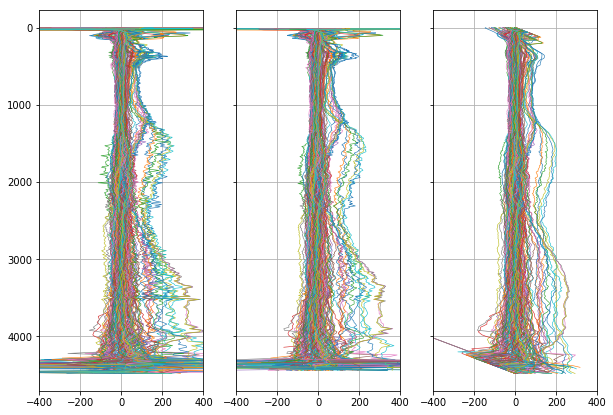

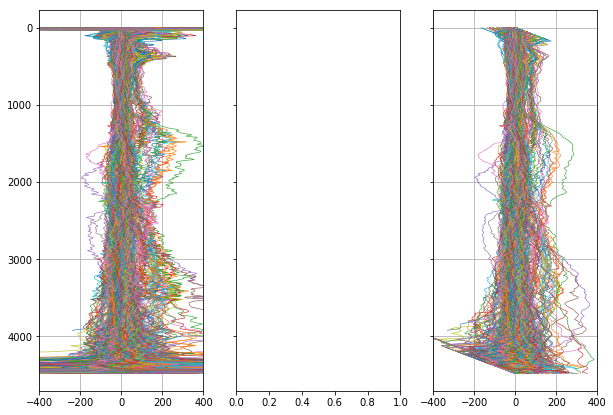

()

In [9]:
matplotlib.rcParams['figure.figsize'] = (10,7)
f, ax = plt.subplots(1, 3, sharey=True)
for i in range(np.shape(avg_sig0_per_dep)[1]):
    ax[0].plot(eta_alt[:, i], grid, linewidth=0.6)
    ax[1].plot(eta_alt_2[:, i], grid, linewidth=0.6)
    ax[2].plot(-1 * eta_alt_3[:, i], grid, linewidth=0.6)
ax[0].set_xlim([-400, 400])
ax[0].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[1].set_xlim([-400, 400])
ax[2].set_xlim([-400, 400])
plot_pro(ax[2])

f, ax = plt.subplots(1, 3, sharey=True)
for i in range(lon.shape[1]):
    ax[0].plot(eta_per_prof[:, i], grid, linewidth=0.6)
    ax[2].plot(-1 * eta_per_prof_3[:, i], grid, linewidth=0.6)
ax[0].set_xlim([-400, 400])
ax[0].invert_yaxis()
ax[0].grid()
ax[2].set_xlim([-400, 400])
plot_pro(ax[2])

In [39]:
# FILTER VELOCITY PROFILES IF THEY ARE TOO NOISY / BAD -- ALSO HAVE TO REMOVE EQUIVALENT ETA PROFILE (non-ind profiles)
# select only velocity profiles that seem reasonable
# criteria are slope of v (dont want kinks)
# criteria: limit surface velocity to greater that 40cm/s
good_v = np.zeros(np.shape(dg_v_0)[1], dtype=bool)
for i in range(np.shape(dg_v_0)[1]):
    dv_dz = np.gradient(dg_v_0[10:-20, i], -1 * grid[10:-20])
    # print(np.nanmax(np.abs(dv_dz)))
    if (np.nanmax(np.abs(dv_dz)) < 0.003) & (np.nanmax(np.abs(eta_alt_3[20:-20, i])) < 750):  # 0.0225
        good_v[i] = True
good_v[np.abs(dg_v_0[5,:]) > 1] = False
        
avg_sig = avg_sig0_per_dep[:, good_v]
eta_alt = eta_alt_3[:, good_v]
dace_mw = dace_mw_0[good_v]
dacn_mw = dacn_mw_0[good_v]
dg_v = dg_v_0[:, good_v]
dg_v_e = dg_v_e_0[:, good_v]
dg_v_n = dg_v_n_0[:, good_v]
dg_mw_time = dg_mw_time_0[good_v]
dg_v_dive_no = dg_v_dive_no_0[good_v]
num_mw_profs = np.shape(eta_alt)[1]

# Smooth DG N2 profiles
dg_avg_N2_coarse = np.nanmean(dg_N2, axis=1)
dg_avg_N2_coarse[np.isnan(dg_avg_N2_coarse)] = dg_avg_N2_coarse[~np.isnan(dg_avg_N2_coarse)][0] - 1*10**(-5)
dg_avg_N2 = savgol_filter(dg_avg_N2_coarse, 15, 3)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: All-NaN slice encountered
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: Mean of empty slice


In [40]:
np.sum(good_v)

128

In [41]:
# EAST/NORTH VELOCITY PROFILES
dg_v_e_avg = np.nanmean(dg_v_e[:, :], axis=1)
dg_v_n_avg = np.nanmean(dg_v_n[:, :], axis=1)
dz_dg_v_e_avg = np.gradient(savgol_filter(dg_v_e_avg, 15, 7), z)
dz_dg_v_n_avg = np.gradient(savgol_filter(dg_v_n_avg, 15, 7), z)

d_sum_v = np.where(((dg_mw_time > bd1) & (dg_mw_time < bd2)))[0]
d_win_w = np.where(((dg_mw_time < 735750) | (dg_mw_time > 735857)) & ((dg_v_dive_no < 60) | (dg_v_dive_no > 71)))[0]

In [42]:
mw_time_ordered_i = np.argsort(dg_mw_time)
dg_mw_time_ordered = dg_mw_time[mw_time_ordered_i]
dg_v_e_ordered = dg_v_e[:, mw_time_ordered_i]
dg_v_n_ordered = dg_v_n[:, mw_time_ordered_i]

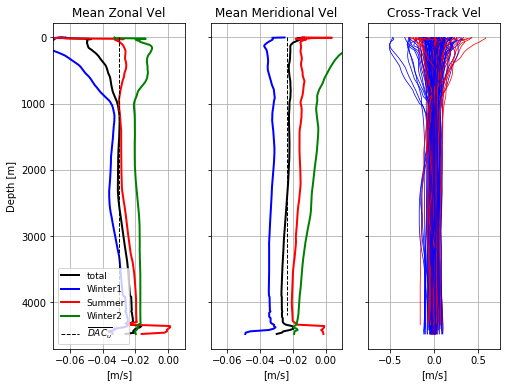

()

In [13]:
# PLOT (non-noisy) EAST/NORTH VELOCITY PROFILES

matplotlib.rcParams['figure.figsize'] = (8,6)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
dz_dg_v = np.nan * np.ones(np.shape(dg_v))
for i in range(np.shape(dg_v_e)[1]):
    tsort = np.where((i - d_sum_v) == 0)[0]
    if np.shape(tsort)[0] > 0:  # in summer profile
        ax3.plot(dg_v[:, i], grid, color='r', linewidth=0.75)
    else:
        ax3.plot(dg_v[:, i], grid, color='b', linewidth=0.75)
    dz_dg_v[:, i] = np.gradient(savgol_filter(dg_v[:, i], 13, 5), z)
dg_mw_time_good = dg_mw_time[:]
dg_v_e_good = dg_v_e[:, :]
dg_v_n_good = dg_v_n[:, :]

d_win1_v_2 = np.where(dg_mw_time_good < bd1)[0]
d_sum_v_2 = np.where(((dg_mw_time_good > bd1) & (dg_mw_time_good < bd2)))[0]
d_win2_v_2 = np.where(dg_mw_time_good > bd2)[0]

ax1.plot(np.nanmean(dg_v_e[:, :], axis=1), grid, color='k', linewidth=2, label='total') # total avg prof
ax1.plot(np.nanmean(dg_v_e_good[:, d_win1_v_2], axis=1), grid, color='b', linewidth=2, label='Winter1')  # winter avg prof
ax1.plot(np.nanmean(dg_v_e_good[:, d_sum_v_2], axis=1), grid, color='r', linewidth=2, label='Summer')  # summer avg prof
ax1.plot(np.nanmean(dg_v_e_good[:, d_win2_v_2], axis=1), grid, color='g', linewidth=2, label='Winter2')  # winter avg prof
ax1.plot(np.nanmean(dace_mw[:]) * np.ones(10), np.linspace(0, 4200, 10),
         color='k', linewidth=1, linestyle='--', label=r'$\overline{DAC_u}$')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=9)

ax2.plot(np.nanmean(dg_v_n[:, :], axis=1), grid, color='k', linewidth=2)
ax2.plot(np.nanmean(dg_v_n_good[:, d_win1_v_2], axis=1), grid, color='b', linewidth=2)  # winter avg prof
ax2.plot(np.nanmean(dg_v_n_good[:, d_sum_v_2], axis=1), grid, color='r', linewidth=2)  # summer avg prof
ax2.plot(np.nanmean(dg_v_n_good[:, d_win2_v_2], axis=1), grid, color='g', linewidth=2)  # winter avg prof
ax2.plot(np.nanmean(dacn_mw[:]) * np.ones(10), np.linspace(0, 4200, 10),
         color='k', linewidth=1, linestyle='--')
ax1.set_xlim([-.07, 0.01])
ax2.set_xlim([-.07, 0.01])
ax3.set_xlim([-.75, .75])
ax1.set_xlabel('[m/s]')
ax2.set_xlabel('[m/s]')
ax3.set_xlabel('[m/s]')
ax1.set_ylabel('Depth [m]')
ax1.invert_yaxis()
ax1.grid()
ax2.grid()
ax1.set_title('Mean Zonal Vel')
ax2.set_title('Mean Meridional Vel')
ax3.set_title('Cross-Track Vel')
plot_pro(ax3)


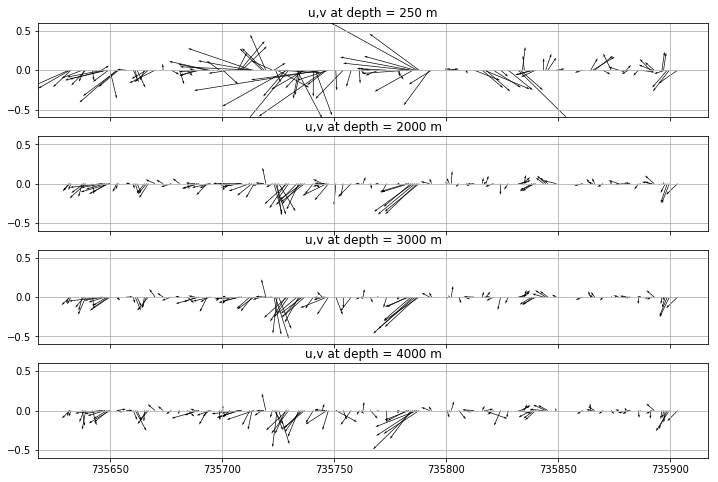

()

In [14]:
matplotlib.rcParams['figure.figsize'] = (12,8)

mw_time_date = []
for i in range(len(dg_mw_time_ordered)):
    mw_time_date.append(datetime.date.fromordinal(np.int(np.round(dg_mw_time_ordered[i]))))

i_i = 50, 250, 350, 425
f, ax = plt.subplots(4, 1, sharex=True)
count = 0
for ii in i_i:
    ax[count].quiver(dg_mw_time_ordered, np.zeros(len(dg_mw_time_ordered)), 
                     dg_v_e_ordered[ii, :], dg_v_n_ordered[ii, :], scale=2.5, width=0.001)
    ax[count].set_title('u,v at depth = ' + str(grid[ii]) + ' m')
    ax[count].set_ylim([-.6, .6])
    count = count + 1
ax[0].grid()
ax[1].grid()
ax[2].grid()
plot_pro(ax[3])

In [45]:
# OUTPUT 

# initial processesing (post m/w)
profile_tags  # profile list
sa  # abs sal profiles
ct  # cons temp profiles 
gamma  # neutral density profiles
time_rec_bin  # profile times 

ref_lon # reference longitude
ref_lat # reference latitude
bckgrds # time indices for splitting profiles into 4 quadrants and spitting by season 
bckgrds_info # key to above 

N2 # N2 split into backgrounds 
salin_avg # avg salin per backgrounds
cons_t_avg # avg cons temp per backgrounds
theta_avg  # avg theta per backgrounds
gamma_avg # avg gamma per backgrounds

dg_mw_time # times tagged to m/w velocity and avg dens profiles 
prof_lon_i # m/w profile longitude
prof_lat_i # m/w profile latitude 
avg_ct_per_dep # m/w avg ct per 4 profiles
avg_sa_per_dep # m/w avg sa per 4 profiles
avg_sig0_per_dep # m/w avg gamma per 4 profiles 
eta_alt  # eta gamma / ddz
eta_alt_2 # eta locally reference density / seasonal avg ddz 
eta_alt_3  # direct search for avg gamma per 4 profiles on seasonal avg gamma 
eta_per_prof # individual eta gamma / seasonal avg ddz
eta_per_prof_3 # individual search for eta gamma on seasonal avg gamma 

good_v # indices selecting good v, eta profiles 
avg_sig # avg gamma per 4 profiles selected 
eta_alt_sel = eta_alt[:, good_v]  # eta selected corresponding to definitions above 
eta_alt_sel_2 = eta_alt_2[:, good_v]
eta_alt_sel_3 = eta_alt_3[:, good_v]
dace_mw  # east component of dac 
dacn_mw  # north component of dac
dg_v  # cross track v profiles 
dg_v_e  # east component of v 
dg_v_n  # north component of v
dg_v_dive_no  # dive no roughly associated with the center dive of the m/w technique 
PE_per_mass_all # PE from indivudal eta profiles (filtered by noise criteria )

0

In [43]:
# SAVING 
sa = 1
if sa > 0:
    my_dict = {'depth': grid, 'raw_profile_tags': profile_tags, 'sa': sa, 'ct': ct, 'gamma': neutral_density, 
               'profile_time': time_rec_bin, 'ref_lon': ref_lon, 'ref_lat': ref_lat, 'background_indices': bckgrds,
               'background key': bckgrds_info, 'bd1': bd1, 'bd2': bd2, 'lon_lim': lon_lim, 'lat_lim': lat_lim,
               'N2_by_season_quad': N2, 'bckgrd_sa': salin_avg, 'bckgrd_ct': cons_t_avg,
               'bckgrd_theta': theta_avg, 'bckgrd_gamma': sigma_theta_avg, 'mw_time': dg_mw_time_0, 'mw_lon': prof_lon_i,
               'mw_lat': prof_lat_i, 'mw_ct': avg_ct_per_dep, 'mw_sa': avg_sa_per_dep, 'mw_gamma': avg_sig0_per_dep,
               'eta_1': eta_alt_0, 'eta_2': eta_alt_2, 'eta_3': eta_alt_3, 'eta_per_1': eta_per_prof, 
               'eta_per_3': eta_per_prof_3, 'mw_prof': dg_v_dive_no_0,
               'good_v_ind': good_v, 'mw_time_good': dg_mw_time,
               'mw_gamma_good': avg_sig, 'eta_1_good': eta_alt_0[:, good_v], 'eta_2_good': eta_alt_2[:, good_v],
               'eta_3_good': eta_alt_3[:, good_v], 'dac_e_mw': dace_mw, 'dac_n_mw': dacn_mw,
               'dg_v_good': dg_v, 'dg_v': dg_v_0, 'dg_v_e_good': dg_v_e, 'dg_v_n_good': dg_v_n, 
               'mw_prof_good': dg_v_dive_no, 'PE_per_prof': PE_per_mass_all}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_initial_processing.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()

In [25]:
np.shape(eta_alt_3)

(450, 261)